In [36]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
from sklearn.model_selection import train_test_split
import utils as utils

import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.layers import LSTM, Dense, Embedding, Input, Concatenate, Dropout

from gensim.models import Word2Vec

from keras.callbacks import Callback, ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import matplotlib.pyplot as plt

In [2]:
# Read the CSV file into a DataFrame
df = pd.read_csv('text_entailment_dataset/train.csv')

# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42)  # Shuffle with fixed seed for reproducibility

# Split the data into training and validation sets
train_df, validation_df = train_test_split(df, test_size=0.2, random_state=42)

train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Write the training and validation DataFrames to separate CSV files
train_df.to_csv('text_entailment_dataset/train_data.csv', index=False)
validation_df.to_csv('text_entailment_dataset/validation_data.csv', index=False)
test_df.to_csv('text_entailment_dataset/test_data.csv', index=False)


train_dataset = df = pd.read_csv('text_entailment_dataset/train_data.csv')
validation_dataset = df = pd.read_csv('text_entailment_dataset/validation_data.csv')
test_dataset = df = pd.read_csv('text_entailment_dataset/test_data.csv')


In [3]:
train_dataset.head()

,premise,hypothesis,label
0,Four guys sitting around a table with two cand...,Four guys are at a church service.,2
1,a little boy using a drill to make a hole in a...,The little boy is using a tool.,0
2,People go by old white walls with gray squares.,Males and females are in proximity of old walls.,0
3,About eight women in purple and blue dresses b...,About eight women in purple and blue dresses.,0
4,Customers are standing in line to buy somethin...,The customers leave the store after a satisfac...,2


In [4]:
train_dataset.shape

(351590, 3)

In [5]:
validation_dataset.head()

,premise,hypothesis,label
0,A young couple looking at different types and ...,a couple is looking,0
1,A man in a purple had climbs a rocky wall with...,A man is going to the temple.,2
2,A group of friends playing cards and trying to...,The people are playing a card game.,0
3,People looking at fish at an aquarium.,People looking at fish.,0
4,An older lady blowing out a 9 and a 0 number c...,A woman drinks coffee while driving.,2


In [6]:
validation_dataset.shape

(109873, 3)

In [7]:
test_dataset.head()

,premise,hypothesis,label
0,A quarterback is looking to set up a pass from...,the men are playing football,0
1,A woman speaking her mind.,A woman talking.,0
2,Woman in a blue jacket sitting at the edge of ...,A woman is at home,2
3,A man stands next to a lady with a dog hat.,A man stands next to a strange homeless lady w...,1
4,A man is vending an assortment of hats.,a man sells hats,0


In [8]:
test_dataset.shape

(87898, 3)

In [9]:
train_dataset[["premise"]] = train_dataset[["premise"]].astype(str)
train_dataset["premise"] = train_dataset["premise"].apply(utils.change_lower)
train_dataset["premise"] = train_dataset["premise"].apply(utils.clean_data)
train_dataset["premise"] = train_dataset["premise"].apply(utils.remover)

test_dataset[["hypothesis"]] = train_dataset[["hypothesis"]].astype(str)
train_dataset["hypothesis"] = train_dataset["hypothesis"].apply(utils.change_lower)
train_dataset["hypothesis"] = train_dataset["hypothesis"].apply(utils.clean_data)
train_dataset["hypothesis"] = train_dataset["hypothesis"].apply(utils.remover)

validation_dataset[["premise"]] = validation_dataset[["premise"]].astype(str)
validation_dataset["premise"] = validation_dataset["premise"].apply(utils.change_lower)
validation_dataset["premise"] = validation_dataset["premise"].apply(utils.clean_data)
validation_dataset["premise"] = validation_dataset["premise"].apply(utils.remover)

validation_dataset[["hypothesis"]] = validation_dataset[["hypothesis"]].astype(str)
validation_dataset["hypothesis"] = validation_dataset["hypothesis"].apply(utils.change_lower)
validation_dataset["hypothesis"] = validation_dataset["hypothesis"].apply(utils.clean_data)
validation_dataset["hypothesis"] = validation_dataset["hypothesis"].apply(utils.remover)

test_dataset[["premise"]] = test_dataset[["premise"]].astype(str)
test_dataset["premise"] = test_dataset["premise"].apply(utils.change_lower)
test_dataset["premise"] = test_dataset["premise"].apply(utils.clean_data)
test_dataset["premise"] = test_dataset["premise"].apply(utils.remover)

test_dataset[["hypothesis"]] = test_dataset[["hypothesis"]].astype(str)
test_dataset["hypothesis"] = test_dataset["hypothesis"].apply(utils.change_lower)
test_dataset["hypothesis"] = test_dataset["hypothesis"].apply(utils.clean_data)
test_dataset["hypothesis"] = test_dataset["hypothesis"].apply(utils.remover)

In [10]:
# Tokenize text data
sentences = train_dataset['premise'].tolist() + train_dataset['hypothesis'].tolist()
sentences = [sentence.split() for sentence in sentences]  # Split sentences into words

word2vec_model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=1, workers=4)

tokenizer = Tokenizer(num_words=len(word2vec_model.wv.key_to_index) + 1)
tokenizer.fit_on_texts(train_dataset['premise'].tolist() + train_dataset['hypothesis'].tolist())

train_premise_sequences = tokenizer.texts_to_sequences(train_dataset['premise'].tolist())
train_hypothesis_sequences = tokenizer.texts_to_sequences(train_dataset['hypothesis'].tolist())

val_premise_sequences = tokenizer.texts_to_sequences(validation_dataset['premise'].tolist())
val_hypothesis_sequences = tokenizer.texts_to_sequences(validation_dataset['hypothesis'].tolist())

test_premise_sequences = tokenizer.texts_to_sequences(test_dataset['premise'].tolist())
test_hypothesis_sequences = tokenizer.texts_to_sequences(test_dataset['hypothesis'].tolist())


max_premise_length = max(len(seq) for seq in train_premise_sequences)
max_hypothesis_length = max(len(seq) for seq in train_hypothesis_sequences)
max_sequence_length = max(max_premise_length, max_hypothesis_length)


train_premise_sequences = pad_sequences(train_premise_sequences, maxlen=max_sequence_length, padding='post')
train_hypothesis_sequences = pad_sequences(train_hypothesis_sequences, maxlen=max_sequence_length, padding='post')

val_premise_sequences = pad_sequences(val_premise_sequences, maxlen=max_sequence_length, padding='post')
val_hypothesis_sequences = pad_sequences(val_hypothesis_sequences, maxlen=max_sequence_length, padding='post')

test_premise_sequences = pad_sequences(test_premise_sequences, maxlen=max_sequence_length, padding='post')
test_hypothesis_sequences = pad_sequences(test_hypothesis_sequences, maxlen=max_sequence_length, padding='post')

embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv.key_to_index:
        embedding_matrix[i] = word2vec_model.wv[word]

print("Size of Vocabulary:", len(tokenizer.word_index))
print("Size of Train Premise Sequences:", len(train_premise_sequences))
print("Size of Train Hypothesis Sequences:", len(train_hypothesis_sequences))


Size of Vocabulary: 31284
Size of Train Premise Sequences: 351590
Size of Train Hypothesis Sequences: 351590


In [11]:
print(max_sequence_length)

45


In [12]:
import pickle

# Save the tokenizer object
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)


In [13]:
print(train_premise_sequences.shape)

(351590, 45)


In [30]:
train_labels = train_dataset["label"]
validation_labels = validation_dataset["label"]
test_labels = test_dataset["label"]

# Convert to one-hot encoded format
num_classes = len(set(train_labels))  # Calculate the number of classes
train_labels = to_categorical(train_labels, num_classes=num_classes)
validation_labels = to_categorical(validation_labels, num_classes=num_classes)
test_labels = to_categorical(test_labels, num_classes=num_classes)

print("train label shape:", train_labels.shape)
print("val label shape:", validation_labels.shape)
print("test label shape:", test_labels.shape)

train label shape: (351590, 3)
val label shape: (109873, 3)
test label shape: (87898, 3)


In [15]:
def data_generator(premise_sequences, hypothesis_sequences, labels, batch_size):
    '''
    Returns a data generator to be used for training or validation.

    Yields batches of separate premise and hypothesis sequences (tokenized) and corresponding labels.

    Args:
      premise_sequences: List of tokenized premise sequences
      hypothesis_sequences: List of tokenized hypothesis sequences
      labels: List of corresponding labels
      batch_size: Number of sequences per batch (premise and hypothesis pairs)

    Returns:
      Data generator
    '''

    num_samples = len(premise_sequences)
    num_batches = (num_samples + batch_size - 1) // batch_size  # Calculate total number of batches
    idx = 0  # Initialize index to keep track of where we are in the dataset

    while True:  # Loop indefinitely to generate batches
        batch_premise_sequences = premise_sequences[idx:idx+batch_size]
        batch_hypothesis_sequences = hypothesis_sequences[idx:idx+batch_size]
        batch_labels = labels[idx:idx+batch_size]

        # Yield the batch (separate premise and hypothesis sequences)
        yield ([batch_premise_sequences, batch_hypothesis_sequences], batch_labels)

        # Move to the next batch
        idx += batch_size

        # If we reach the end of the dataset, start over
        if idx + batch_size > num_samples:
            idx = 0

In [16]:
batch_size = 32
train_generator = data_generator(train_premise_sequences, train_hypothesis_sequences, train_labels, batch_size)
val_generator = data_generator(val_premise_sequences, val_hypothesis_sequences, validation_labels, batch_size)

steps_per_epoch = len(train_premise_sequences) // batch_size
validation_steps = len(val_premise_sequences) // batch_size

In [17]:
sample_batch_X, sample_batch_y = next(train_generator)
print(sample_batch_X[0].shape)
print(sample_batch_X[1].shape)
print(sample_batch_y.shape)

sample_batch_X, sample_batch_y = next(val_generator)
print(sample_batch_X[0].shape)
print(sample_batch_X[1].shape)
print(sample_batch_y.shape)

(32, 45)
(32, 45)
(32, 3)
(32, 45)
(32, 45)
(32, 3)


In [18]:
class MetricsCallback(Callback):
    def __init__(self, val_premise_sequences, val_hypothesis_sequences, val_labels):
        super(MetricsCallback, self).__init__()
        self.val_premise_sequences = val_premise_sequences
        self.val_hypothesis_sequences = val_hypothesis_sequences
        self.val_labels = val_labels
        self.metrics = {'epoch': [], 'precision': [], 'recall': [], 'f1': [], 'val_loss': [], 'val_accuracy': [], 'loss': [], 'accuracy': []}

    def on_epoch_end(self, epoch, logs=None):
        val_loss, val_accuracy = self.model.evaluate(
            [self.val_premise_sequences, self.val_hypothesis_sequences], self.val_labels, verbose=0)
        val_pred = self.model.predict([self.val_premise_sequences, self.val_hypothesis_sequences])
        val_pred_classes = np.argmax(val_pred, axis=1)  # Convert probabilities to classes

        precision = precision_score(np.argmax(self.val_labels, axis=1), val_pred_classes, average='weighted')
        recall = recall_score(np.argmax(self.val_labels, axis=1), val_pred_classes, average='weighted')
        f1 = f1_score(np.argmax(self.val_labels, axis=1), val_pred_classes, average='weighted')

        self.metrics['epoch'].append(epoch + 1)
        self.metrics['precision'].append(precision)
        self.metrics['recall'].append(recall)
        self.metrics['f1'].append(f1)
        self.metrics['val_loss'].append(val_loss)
        self.metrics['val_accuracy'].append(val_accuracy)
        self.metrics['loss'].append(logs['loss'])
        self.metrics['accuracy'].append(logs['accuracy'])

        print("Epoch {}: Validation Precision = {:.4f}, Recall = {:.4f}, F1 Score = {:.4f}, Val Loss = {:.4f}, Val Accuracy = {:.4f}".format(epoch + 1, precision, recall, f1, val_loss, val_accuracy))

In [19]:
metrics_callback = MetricsCallback(val_premise_sequences, val_hypothesis_sequences, validation_labels)

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

In [20]:
# Define embedding layer based on embedding matrix (assuming pre-trained Word2Vec)
embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],
                            output_dim=embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            trainable=False)

# Input layers for premise and hypothesis sequences
premise_input = Input(shape=(max_sequence_length,))
hypothesis_input = Input(shape=(max_sequence_length,))

# Embedding layers for premise and hypothesis inputs
embedded_premise = embedding_layer(premise_input)
embedded_hypothesis = embedding_layer(hypothesis_input)

# LSTM layers for premise and hypothesis sequences
premise_lstm = LSTM(units=67, dropout=0.2783331011414365)(embedded_premise)
hypothesis_lstm = LSTM(units=67, dropout=0.2783331011414365)(embedded_hypothesis)

# Concatenate LSTM outputs
combined_lstm = Concatenate()([premise_lstm, hypothesis_lstm])

# Final dense layers for prediction with 3 outputs (entailment, neutral, contradiction)
dense1 = Dense(units=89, activation='relu')(combined_lstm)
dense1_dropout = Dropout(0.13998996632720118)(dense1)  # Add dropout after dense layer
output = Dense(units=3, activation='softmax')(dense1_dropout)

# Define the model with premise and hypothesis sequence inputs
model = tf.keras.Model(inputs=[premise_input, hypothesis_input], outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001000649183264211),
              loss='categorical_crossentropy',  # Use categorical cross-entropy for one-hot encoded labels
              metrics=['accuracy'])

In [21]:
print(len(train_premise_sequences))
print(len(val_premise_sequences))

351590
109873


In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 45)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 45)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 45, 100)      3128500     ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lstm (LSTM)                    (None, 67)           45024       ['embedding[0][0]']          

In [23]:
history = model.fit(train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=10,
                              validation_data=val_generator,
                              validation_steps=validation_steps,
                              callbacks=[metrics_callback, checkpoint])

Epoch 1/10
3434/3434 [==============================] - 21s 6ms/step
Epoch 1: Validation Precision = 0.5918, Recall = 0.5891, F1 Score = 0.5886, Val Loss = 0.8942, Val Accuracy = 0.5891

Epoch 1: val_loss improved from inf to 0.89422, saving model to best_model.h5
10987/10987 [==============================] - 219s 20ms/step - loss: 0.9535 - accuracy: 0.5450 - val_loss: 0.8942 - val_accuracy: 0.5891
Epoch 2/10
3434/3434 [==============================] - 17s 5ms/step
Epoch 2: Validation Precision = 0.6035, Recall = 0.5998, F1 Score = 0.5983, Val Loss = 0.8721, Val Accuracy = 0.5998

Epoch 2: val_loss improved from 0.89422 to 0.87210, saving model to best_model.h5
10987/10987 [==============================] - 212s 19ms/step - loss: 0.9006 - accuracy: 0.5806 - val_loss: 0.8721 - val_accuracy: 0.5998
Epoch 3/10
3434/3434 [==============================] - 17s 5ms/step
Epoch 3: Validation Precision = 0.6088, Recall = 0.6033, F1 Score = 0.6017, Val Loss = 0.8664, Val Accuracy = 0.6033

Epo

In [24]:
epochs = metrics_callback.metrics['epoch']
precision = metrics_callback.metrics['precision']
recall = metrics_callback.metrics['recall']
f1 = metrics_callback.metrics['f1']
accuracy = metrics_callback.metrics['accuracy']
loss = metrics_callback.metrics['loss']
val_accuracy = metrics_callback.metrics['val_accuracy']
val_loss = metrics_callback.metrics['val_loss']

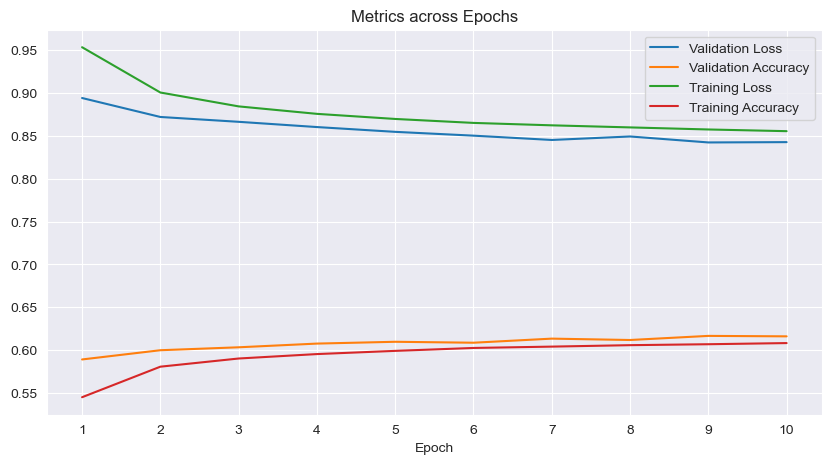

In [25]:
# Plot all four metrics on one graph
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_loss, label='Validation Loss')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, accuracy, label='Training Accuracy')

plt.title('Metrics across Epochs')
plt.xlabel('Epoch')
plt.xticks(epochs)
plt.legend()
plt.savefig("LSTM_RNN_val_loss_acc.pdf")  # Save the plot before showing
plt.show()


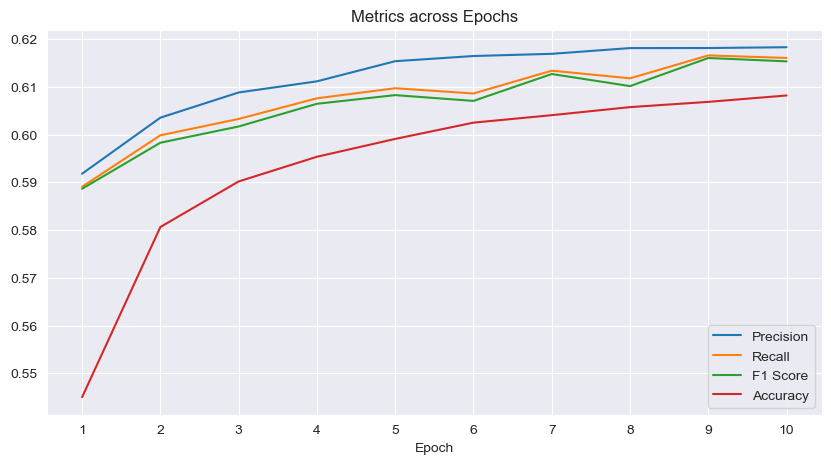

In [26]:
# Plot all four metrics on one graph
plt.figure(figsize=(10, 5))
plt.plot(epochs, precision, label='Precision')
plt.plot(epochs, recall, label='Recall')
plt.plot(epochs, f1, label='F1 Score')
plt.plot(epochs, accuracy, label='Accuracy')

plt.title('Metrics across Epochs')
plt.xlabel('Epoch')
plt.xticks(epochs)
plt.legend()
plt.savefig("LSTM_RNN_PRFA.pdf")
plt.show()

In [37]:
# Predict probabilities on the test set
y_pred = model.predict([test_premise_sequences, test_hypothesis_sequences])

# Calculate performance metrics
test_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to classes

accuracy = accuracy_score(np.argmax(test_labels, axis=1), test_pred_classes)
precision = precision_score(np.argmax(test_labels, axis=1), test_pred_classes, average='weighted')
recall = recall_score(np.argmax(test_labels, axis=1), test_pred_classes, average='weighted')
f1 = f1_score(np.argmax(test_labels, axis=1), test_pred_classes, average='weighted')

print("Final Test Accuracy:", accuracy)
print("Final Test Precision:", precision)
print("Final Test Recall:", recall)
print("Final Test F1 Score:", f1)

2747/2747 [==============================] - 13s 5ms/step
Final Test Accuracy: 0.33202120639832533
Final Test Precision: 0.3317816270808972
Final Test Recall: 0.33202120639832533
Final Test F1 Score: 0.3309799910218677
